In [2]:
import glob, re, os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [28]:
from scipy.stats import pearsonr, ttest_ind
from scipy.optimize import curve_fit

In [2]:
sp_pattern = re.compile('SAO PAULO - MIRANTE')
sp_files = [file for file in glob.glob(f'data/*') if sp_pattern.search(file)]

sp_files

['data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2007_A_31-12-2007.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2008_A_31-12-2008.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2009_A_31-12-2009.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2010_A_31-12-2010.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2011_A_31-12-2011.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2012_A_31-12-2012.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2013_A_31-12-2013.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2014_A_31-12-2014.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2015_A_31-12-2015.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2016_A_31-12-2016.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2017_A_31-12-2017.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2018_A_31-12-2018.CSV',
 'data\\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2019_A_31-12-2019.CSV',
 'data\\INMET_SE_SP_A701_

In [17]:
rename_dict = {
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'prec',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'press',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'press_max',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'press_min',
    'RADIACAO GLOBAL (KJ/m²)': 'rad',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'tdew',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'tmax',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'tmin',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'tdew_max',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'tdew_min',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'umid_max',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'umid_min',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umid',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wdir', 
    'VENTO, RAJADA MAXIMA (m/s)': 'gust',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'wspd'
}

<Axes: xlabel='datetime'>

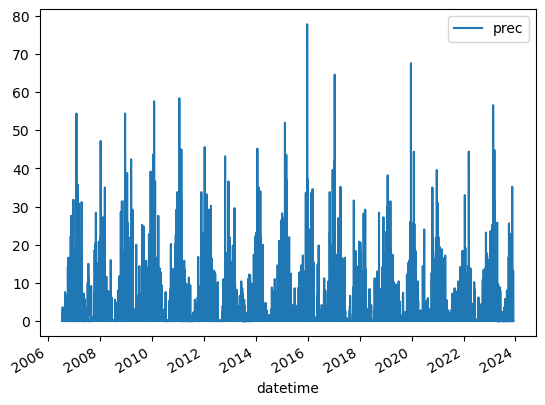

In [18]:
dfs = []
col_names = None
for sp_file in sp_files:
    res = pd.read_csv(sp_file, sep=';', skiprows=8, decimal=',', encoding='utf-8')
    time = pd.to_datetime(res[res.columns[:2]].apply(lambda row: row.str.cat(sep='T'), axis=1), utc=True)
    res = res[res.columns[2:-1]].set_index(pd.Index(time, name='datetime'))
    res = res.replace(-9999, np.nan)
    res = res.rename(columns={'RADIACAO GLOBAL (Kj/m²)': 'RADIACAO GLOBAL (KJ/m²)'})
    res = res.rename(columns=rename_dict)

    dfs.append(res)
    
df = pd.concat(dfs, axis=0).sort_index()
df = df[~((df.index.day == 29) & (df.index.month == 2))]
df[df.columns[:1]].plot()

In [25]:
-np.sin(np.radians(df['wdir'])) * df['wspd']
-np.cos(np.radians(df['wdir'])) * df['wspd']

datetime
2006-07-25 00:00:00+00:00         NaN
2006-07-25 01:00:00+00:00         NaN
2006-07-25 02:00:00+00:00         NaN
2006-07-25 03:00:00+00:00         NaN
2006-07-25 04:00:00+00:00         NaN
                               ...   
2023-11-30 19:00:00+00:00   -3.262708
2023-11-30 20:00:00+00:00    0.938943
2023-11-30 21:00:00+00:00    1.443330
2023-11-30 22:00:00+00:00   -0.143868
2023-11-30 23:00:00+00:00    0.347329
Length: 152016, dtype: float64

In [26]:
df.sort_index().to_csv('data/sp_mirante.csv')

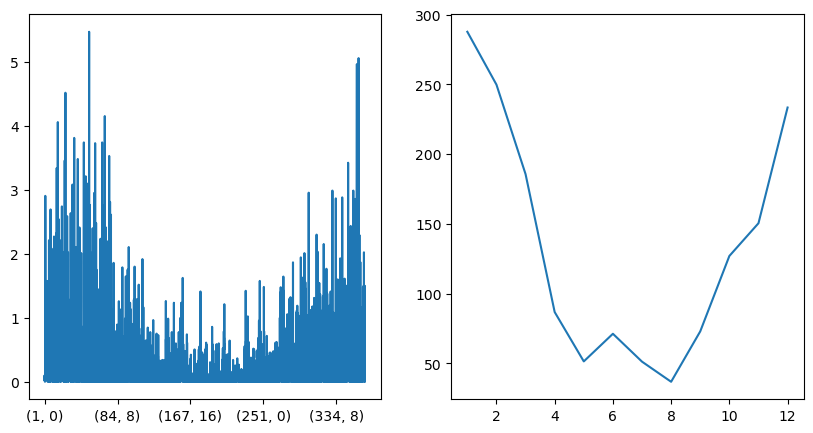

In [137]:
prec_base = df[df.columns[:1]] # - df[df.columns[:1]].mean()
prec_year = prec_base.groupby([prec_base.index.day_of_year, prec_base.index.hour]).mean()

# arr = prec_year.values.ravel()
# for _ in range(300): arr = np.correlate(np.pad(arr, (1, 1), 'reflect'), [0.25, 0.5, 0.25])

fig, axs = plt.subplots(1, 2, figsize=(10., 5.))
prec_year.plot(ax=axs[0])

prec_month = df[df.columns[:1]].groupby(pd.Grouper(freq='M')).sum()
prec_month.groupby([prec_month.index.month]).mean().plot(ax=axs[1])

axs[0].get_legend().remove()
axs[1].get_legend().remove()

# axs[0].xaxis.set_major_formatter(lambda x, pos: prec_year.index[int(x)])

<Axes: >

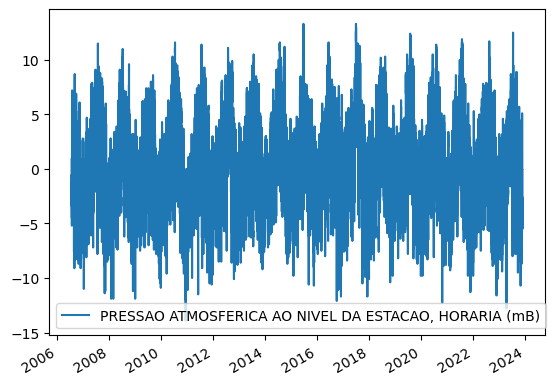

In [140]:
df[df.columns[1:2]] - df[df.columns[1:2]].mean()


In [12]:
df_inmet = pd.read_csv('data/sp_mirante.csv', index_col=0, parse_dates=['datetime']).rename(columns={'prec': 'prec_inmet'})
df_era5 = pd.read_csv('data/era5_prec_mensal.csv', index_col=0, parse_dates=['datetime']).rename(columns={'prec': 'prec_era5'})
df_era5 = df_era5.set_index(pd.to_datetime(df_era5.index, utc=True))

In [14]:
df = pd.concat((df_inmet[['prec_inmet']].resample('M').sum(), df_era5), axis=1).dropna()

In [20]:
pearsonr(df['prec_era5'], df['prec_inmet'])

PearsonRResult(statistic=0.8806631410456244, pvalue=9.138729855865841e-69)

In [29]:
ttest_ind(df['prec_era5'], df['prec_inmet'])

Ttest_indResult(statistic=-1.699501987014567, pvalue=0.08997580104234945)

In [22]:
f = lambda x, a, b: x*a + b
params, _ = curve_fit(f, df['prec_era5'], df['prec_inmet'])

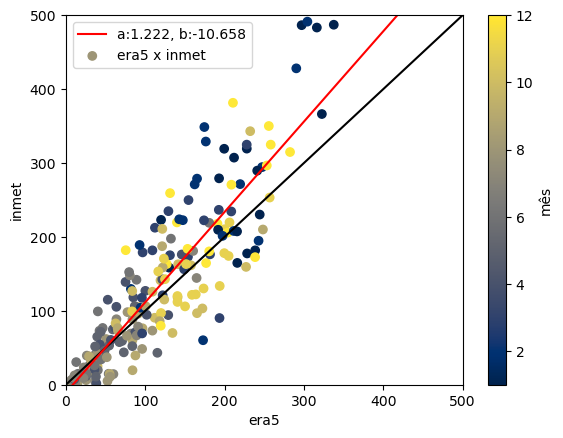

In [36]:
plt.plot(np.linspace(0, 500, 2), np.linspace(0, 500, 2), 'k')
plt.plot(np.linspace(0, 500, 2), f(np.linspace(0, 500, 2), *params), 'r', label='a:%.3f, b:%.3f'%(*params,))
# plt.plot(df['prec_era5'], df['prec_inmet'], 'bo', label='era5 x inmet')

plt.scatter(df['prec_era5'], df['prec_inmet'], c=df.index.month, label='era5 x inmet', cmap='cividis')
plt.colorbar(label='mês')

plt.xlabel('era5')
plt.ylabel('inmet')
plt.axis([0, 500, 0, 500])
plt.legend()